In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.wcs import WCS
import scipy.ndimage as ndimage
import naima
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import healpy as hp

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm

from ClusterModel import model
from ClusterModel.ClusterTools import map_tools
from ClusterModel.ClusterTools import cluster_profile
from ClusterModel.ClusterTools import cluster_spectra
from ClusterModel.ClusterTools import cluster_global
from ClusterModel.ClusterTools import cluster_xspec

In [2]:
outdir = '/Users/adam/Desktop/Test'

dat_dir = os.getenv('CTAPHYS_EDAT_DIR')

pspc_data_file = dat_dir+'/ROSAT/RASS_1_2048.fits'
pspc_sp_file = dat_dir+'/ROSAT/spectrum.sp'
pspc_resp_file = dat_dir+'/ROSAT/pspcb_gain1_256.rsp'
lab_file = dat_dir+'/ROSAT/HI_LAB_II_1_256_nh.fits'
Xband = [0.1*u.keV, 2.4*u.keV]

reso_out = 1.0/60          # Pixel size in deg
FoV_out  = 3.0             # Size of the field of view

# QUICK TEST

In [3]:
cluster = model.Cluster()

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.


# Development of X-ray observables

In [4]:
cluster = model.Cluster(silent=False)

cluster.output_dir = outdir
cluster.coord = SkyCoord("194.95d  27.94d", frame="icrs", unit="deg")
cluster.map_coord = cluster.coord
cluster.map_fov = FoV_out*u.deg
cluster.map_reso = reso_out*u.deg
cluster.R500 = 1.31*u.Mpc           # Planck paper
cluster.R_truncation = 3*cluster.R500
cluster.redshift = 0.023
cluster.hse_bias = 0.0
# From Xi et al. (2018):
cluster.density_gas_model = {'name':'beta', 'beta':2.0/3, 'r_c':290*u.kpc, 'n_0':3e-3*u.cm**-3}
# From Planck PIPX (2013):
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3,'a':1.8,'b':3.1,'c':0.0,'c500':2.9}

xmap, header = map_tools.roi_extract_healpix(pspc_data_file,
                                             cluster.coord.ra.to_value('deg'), cluster.coord.dec.to_value('deg'), 
                                             cluster.map_reso.to_value('deg'), 
                                             [cluster.map_fov[0].to_value('deg'), cluster.map_fov[1].to_value('deg')], 
                                             visu=False)
cluster.map_header = header

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.
Setting output_dir value
Setting coord value
Getting the coordinates
Setting the map coordinates
Setting: map_header to None, as map properties are now set by hand
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand
Setting R500 value
Setting: theta500, M500 ; Fixing: redshift, cosmo, D_ang
Getting R500 value
Setting R_trunca

In [5]:
cluster.make_xspec_table(Emin=Xband[0], Emax=Xband[1],
                         Tmin=0.1*u.keV, Tmax=30.0*u.keV, nbin=100,
                         file_HI=lab_file, visu_nH=False,
                         model='APEC',
                         resp_file=pspc_resp_file, data_file=pspc_sp_file, app_nH_model=False)
r, T = cluster.get_temperature_gas_profile()
C,S,R = cluster._itpl_xspec_table(cluster.output_dir+'/XSPEC_table.txt', T)
C,S,R

<type 'float'>


/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Getting the output_dir value


(<Quantity [0.9593752 , 0.95937576, 0.95937642, 0.95937718, 0.95937807,
            0.95937909, 0.95938029, 0.95938167, 0.95938328, 0.95938513,
            0.95938728, 0.95938976, 0.95939262, 0.95939593, 0.95939973,
            0.95940411, 0.95940914, 0.95941491, 0.95942152, 0.95942908,
            0.95943771, 0.95944755, 0.95945874, 0.95947143, 0.95948578,
            0.95950198, 0.9595202 , 0.95954061, 0.95956338, 0.95958868,
            0.95961662, 0.95964731, 0.95968075, 0.95971689, 0.95975555,
            0.95979636, 0.95983877, 0.95988193, 0.95992464, 0.95996524,
            0.96000154, 0.96003063, 0.9600488 , 0.96005135, 0.96003248,
            0.95998507, 0.95990063, 0.95976923, 0.95957951, 0.9593189 ,
            0.95897404, 0.95853147, 0.95797879, 0.95730617, 0.95650852,
            0.95558811, 0.95455778, 0.95344454, 0.95229355, 0.95117138,
            0.9501679 , 0.94939618, 0.9489891 , 0.9490922 , 0.94985262,
            0.95140581, 0.95386304, 0.95730514, 0.96179715, 0.96

Getting D_ang value


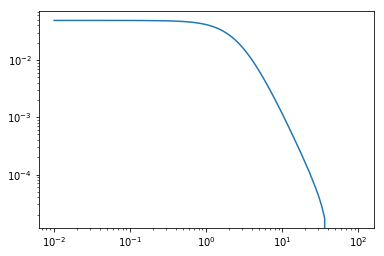

In [6]:
r, sx = cluster.get_xray_profile(output_type='R')
plt.loglog(r/cluster.D_ang, sx.to_value('s-1 arcmin-2'))

Getting R500 value
Getting R_truncation value
Getting R500 value
Getting R_truncation value
(276.2654246874703, 350.40151791851633)


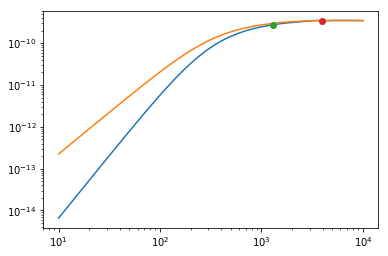

In [7]:
t = 'S'
radius = np.logspace(1,4,100)*u.kpc
fsph = cluster.get_xray_flux(Rmax=radius, Rmin=0.1*u.kpc, Rmin_los=0.1*u.kpc, output_type=t,type_integral='spherical')
fcyl = cluster.get_xray_flux(Rmax=radius, Rmin=0.1*u.kpc, Rmin_los=0.1*u.kpc, output_type=t,type_integral='cylindrical')

f500 = cluster.get_xray_flux(Rmax=cluster.R500, Rmin=0.1*u.kpc, Rmin_los=0.1*u.kpc, type_integral='spherical', output_type=t)
ftrunc = cluster.get_xray_flux(Rmax=cluster.R_truncation, Rmin=0.1*u.kpc, Rmin_los=0.1*u.kpc, type_integral='spherical', output_type=t)

plt.loglog(radius,fsph)
plt.loglog(radius,fcyl)
plt.loglog(cluster.R500, f500, 'o')
plt.loglog(cluster.R_truncation.to('kpc'), ftrunc, 'o')

print(f500.to_value('erg s-1 cm-2')*1e12, ftrunc.to_value('erg s-1 cm-2')*1e12)

In [8]:
# Get the model ymaps
FWHM = 5*u.arcmin
h = cluster.get_map_header()
m = cluster.get_xray_map(output_type='R')

FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))
m = ndimage.gaussian_filter(m, sigma=FWHM2sigma*FWHM.to_value('deg')/reso_out, order=0)*m.unit
xmap_s = ndimage.gaussian_filter(xmap, sigma=FWHM2sigma*np.sqrt(FWHM.to_value('deg')**2-(1.8/60)**2)/reso_out, order=0)

Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates


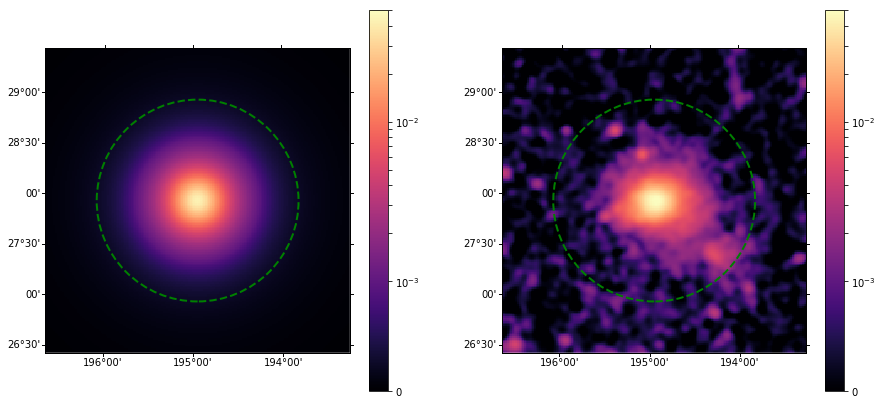

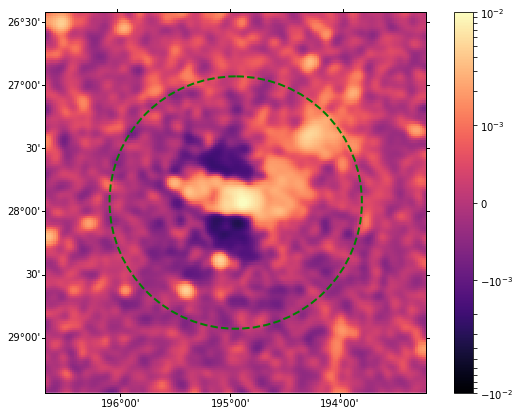

In [9]:
rad_show = 1.0
coeff = 5.24559/(hp.nside2resol(2048, arcmin=True)**2)
bkg = np.median(xmap*coeff - m.to_value('s-1 arcmin-2'))

fig = plt.figure(1, figsize=(15, 7))

# Model 1
ax1 = plt.subplot(121, projection=WCS(h))
plt.imshow(m.to_value('s-1 arcmin-2'), vmin=0, origin='lower', cmap='magma', norm=SymLogNorm(1e-3, vmin=0, vmax=5e-2))
circle_500 = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),
                                        2*rad_show/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax1.get_transform('fk5'))
ax1.add_patch(circle_500)
plt.colorbar()


# Data
ax2 = plt.subplot(122, projection=WCS(h))
plt.imshow(xmap_s*coeff-bkg, vmin=0, origin='lower', cmap='magma', norm=SymLogNorm(1e-3, vmin=0, vmax=5e-2))
circle_500 = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),
                                        2*rad_show/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax2.get_transform('fk5'))
ax2.add_patch(circle_500)
plt.colorbar()

# Data - model scaled
fig = plt.figure(2, figsize=(10, 7))
ax = plt.subplot(111, projection=WCS(h))
plt.imshow(xmap_s*coeff-bkg - m.to_value('s-1 arcmin-2'), cmap='magma', norm=SymLogNorm(1e-3, vmin=-1e-2, vmax=1e-2))
circle_500 = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),
                                        2*rad_show/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle_500)
plt.colorbar()

# Test impact of metalicity and EBL

(0.25, 'dominguez')
(0.0, 'dominguez')
(0.0, 'none')


/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


(10, 100)

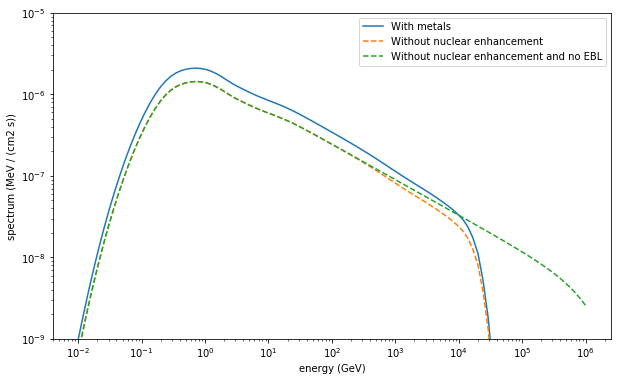

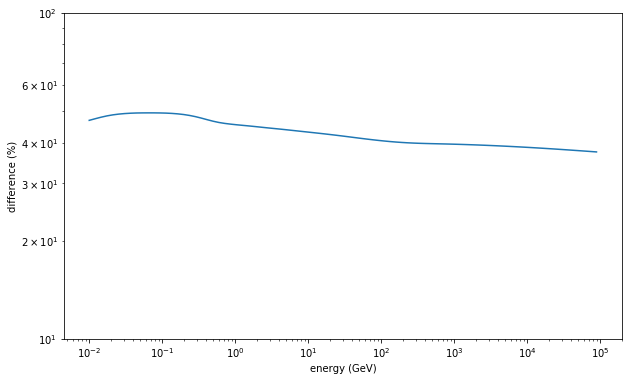

In [10]:
cluster = model.Cluster(silent=True)

cluster.abundance = 0.3
cluster.helium_mass_fraction = 0.25
e1, s1 = cluster.get_gamma_spectrum()
print(cluster.helium_mass_fraction, cluster._EBL_model)

cluster.abundance = 0.0
cluster.helium_mass_fraction = 0.0
e2, s2 = cluster.get_gamma_spectrum()
print(cluster.helium_mass_fraction, cluster._EBL_model)

cluster.abundance = 0.0
cluster.helium_mass_fraction = 0.0
cluster.EBL_model = 'none'
e3, s3 = cluster.get_gamma_spectrum()
print(cluster.helium_mass_fraction, cluster._EBL_model)

spec1 = (e1**2*s1).to('MeV cm-2 s-1')
spec2 = (e2**2*s2).to('MeV cm-2 s-1')
spec3 = (e3**2*s3).to('MeV cm-2 s-1')

fig = plt.figure(figsize=(10,6))
plt.loglog(e1, spec1, label='With metals')
plt.loglog(e2, spec2, '--', label='Without nuclear enhancement')
plt.loglog(e3, spec3, '--', label='Without nuclear enhancement and no EBL')
plt.ylabel('spectrum ('+str(spec1.unit)+')')
plt.xlabel('energy (GeV)')
plt.ylim(1e-9, 1e-5)
plt.legend()

fig = plt.figure(figsize=(10, 6))
plt.loglog(e1, (spec1-spec2)/spec2*100)
plt.ylabel('difference (%)')
plt.xlabel('energy (GeV)')
plt.ylim(10, 100)

# Test auto-plot tools

In [11]:
cluster = model.Cluster(silent=True)

In [12]:
cluster.output_dir = outdir
cluster.map_fov = 10*u.deg
cluster.plot()

# Test saving data

In [13]:
cluster = model.Cluster(silent=True)
cluster.output_dir = outdir

In [14]:
cluster.save_spectra()
cluster.save_profile()
cluster.save_map()

In [15]:
new_table = Table.read(cluster.output_dir+'/SPECTRA.fits')

In [16]:
new_table

Energy,CRp,CRe,gamma,gammaF,nu,nuF,IC,ICF
MeV,1 / MeV,1 / MeV,1 / (cm2 MeV s),1 / (cm2 s),1 / (cm2 MeV s),1 / (cm2 s),1 / (cm2 MeV s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64
10.0,0.0,2.96158917799773e+60,1.0355900105646532e-11,1.7122669322125847e-08,8.769766020112929e-12,1.450019249810489e-08,1.3824659272843232e-10,1.1407714851475825e-09
12.328467394420658,0.0,2.8968147569396794e+60,1.4725222135593167e-11,1.7111485287871452e-08,1.2469872382500883e-11,1.4490721482223493e-08,8.700007883921251e-11,8.889987499205382e-10
15.199110829529339,0.0,2.8062891992612138e+60,2.0185626034114895e-11,1.706869459803578e-08,1.7093947941054984e-11,1.4454484748644234e-08,5.4747211614817866e-11,6.904687869826067e-10
18.73817422860384,0.0,2.681389523568316e+60,2.6489960042318347e-11,1.6982452017521526e-08,2.2432695283204394e-11,1.4381451305907178e-08,3.4451458109810575e-11,5.346901976481566e-10
23.101297000831604,0.0,2.5229110032786066e+60,3.319607359521602e-11,1.684009903576036e-08,2.8111684667348244e-11,1.4260901366553074e-08,2.168091069018534e-11,4.147344888411317e-10
28.48035868435802,0.0,2.309337477794002e+60,3.974426170209056e-11,1.6656569305572565e-08,3.3656936839263684e-11,1.4105481523522693e-08,1.36454475556251e-11,3.227656145132848e-10
35.11191734215131,0.0,2.0461482548055477e+60,4.557884033174424e-11,1.6374321238604494e-08,3.859787764460368e-11,1.3866463263789898e-08,8.589138487413608e-12,2.504051655455413e-10
43.28761281083057,0.0,1.741537274139614e+60,5.0210041679010623e-11,1.5970688518856114e-08,4.251975327040402e-11,1.3524651897190916e-08,5.407163519420538e-12,1.9372495887928367e-10


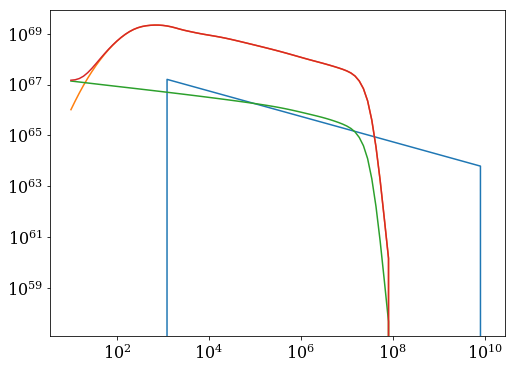

In [17]:
plt.loglog(new_table['Energy'], new_table['Energy']**2*new_table['CRp'])
plt.loglog(new_table['Energy'], new_table['Energy']**2*new_table['gamma']*1e75)
plt.loglog(new_table['Energy'], new_table['Energy']**2*new_table['IC']*1e75)
plt.loglog(new_table['Energy'], new_table['Energy']**2*(new_table['IC']+new_table['gamma'])*1e75)


# Test header from external data

In [18]:
cluster = model.Cluster(silent=True)
cluster.output_dir = outdir
hdul = fits.open('/Users/adam/Project/NIKA/Data/External_data/TaurusMainFilament/taurusN3-070.fits')
header = hdul[0].header
cluster.map_header = header
cluster.coord = SkyCoord("04h25m23.0s +27d03m18s", frame="icrs", unit="deg") # Perseus
cluster.save_map()

# Test saving/loading parameters

In [19]:
cluster.M500 = 1.1431e14*u.Msun
cluster.save_param()

In [20]:
cluster2 = model.Cluster()
cluster2.load_param(cluster.output_dir+'/parameters.pkl')
cluster2.print_param()

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.
--- theta_truncation
    6.08920371533 deg
    <class 'astropy.units.quantity.Quantity'>
--- coord
    <SkyCoord (ICRS): (ra, dec) in deg
    (66.34583333, 27.055)>
    <class 'astropy.coordinates.sky_coordinate.SkyCoord'>
--- abundance
    0.3
    <type 'float'>
--- R_truncation
    4646.03293949 kpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    1.1431e+14 solMass
    <class 'astropy.units.quantity.Quantity'>
--- hse_bias
    0.2
    <type 'float'>
--- E

In [21]:
cluster.print_param()

--- theta_truncation
    6.08920371533 deg
    <class 'astropy.units.quantity.Quantity'>
--- abundance
    0.3
    <type 'float'>
--- R_truncation
    4646.03293949 kpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    1.1431e+14 solMass
    <class 'astropy.units.quantity.Quantity'>
--- map_reso
    None
    <type 'NoneType'>
--- theta500
    0.985070523778 deg
    <class 'astropy.units.quantity.Quantity'>
--- Rmin
    1.0 kpc
    <class 'astropy.units.quantity.Quantity'>
--- magfield_model
    {'a': 1.33, 'c500': 1.81, 'c': 0.155, 'b': 2.065, 'name': 'GNFW', 'r_p': <Quantity 855.62300911 kpc>, 'P_0': <Quantity 10. uG>}
    <type 'dict'>
--- density_gas_model
    {'a': 1.33, 'c500': 1.81, 'c': 0.31, 'b': 4.13, 'name': 'GNFW', 'r_p': <Quantity 855.62300911 kpc>, 'P_0': <Quantity 0.00251972 1 / cm3>}
    <type 'dict'>
--- Epmin
    1.21793391659 GeV
    <class 'astropy.units.quantity.Quantity'>
--- pp_interaction_model
    Pythia8
    <type 'str'>
--- R500
    751.604038089 kpc


# Test Gamma ray computation

In [22]:
cluster = model.Cluster(silent=True)
cluster.redshift = 0.012
cluster.map_fov = 10*u.deg
cluster.map_reso = 0.01*u.deg

In [23]:
m = cluster.get_gamma_map(Normalize=True)
header = cluster.get_map_header()

map_tools.get_map_norm(m.to_value('sr-1'), header)

1.0009092659344485

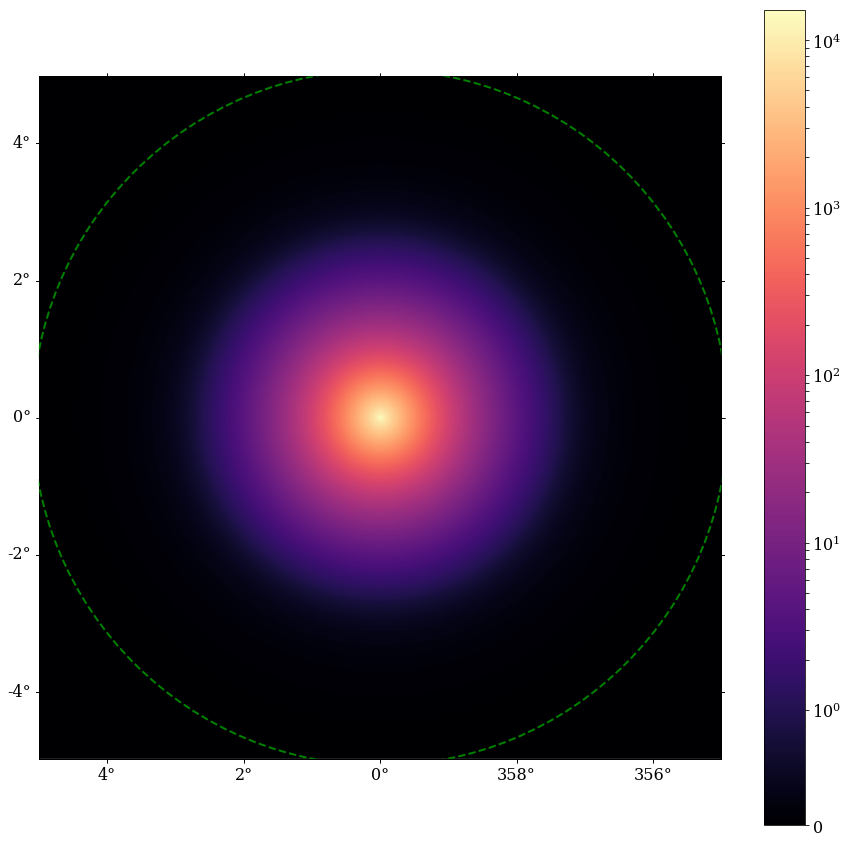

In [24]:
rad_show = cluster.theta_truncation.to_value('deg')
plt.figure(0, figsize=(15,15))
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(m.to_value('sr-1'), vmin=0,origin='lower', cmap='magma', norm=SymLogNorm(1))
circle_500 = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),
                                        2*rad_show/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle_500)
plt.colorbar()

(1e-15, 1e-07)

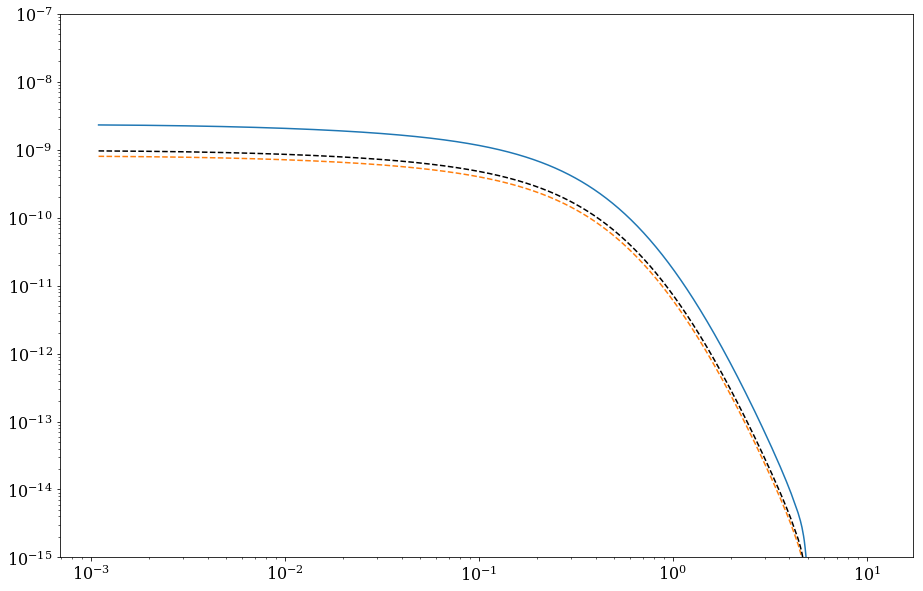

In [25]:
cluster.EBL_model = 'dominguez'
r1, p1 = cluster.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                 Emin=500*u.GeV, Emax=1*u.PeV, Energy_density=False)
r2, p2 = cluster.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                 Emin=1000*u.GeV, Emax=10*u.PeV, Energy_density=False)
cluster.EBL_model = 'none'
r3, p3 = cluster.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                 Emin=1000*u.GeV, Emax=10*u.PeV, Energy_density=False)

plt.figure(0,figsize=(15,10))
plt.loglog((r1/cluster.D_ang*u.rad).to('deg'),p1.to('cm-2 s-1 sr-1'), '-')
plt.loglog((r2/cluster.D_ang*u.rad).to('deg'),p2.to('cm-2 s-1 sr-1'), '--')
plt.loglog((r3/cluster.D_ang*u.rad).to('deg'),p3.to('cm-2 s-1 sr-1'), 'k--')
plt.ylim(1e-15, 1e-7)

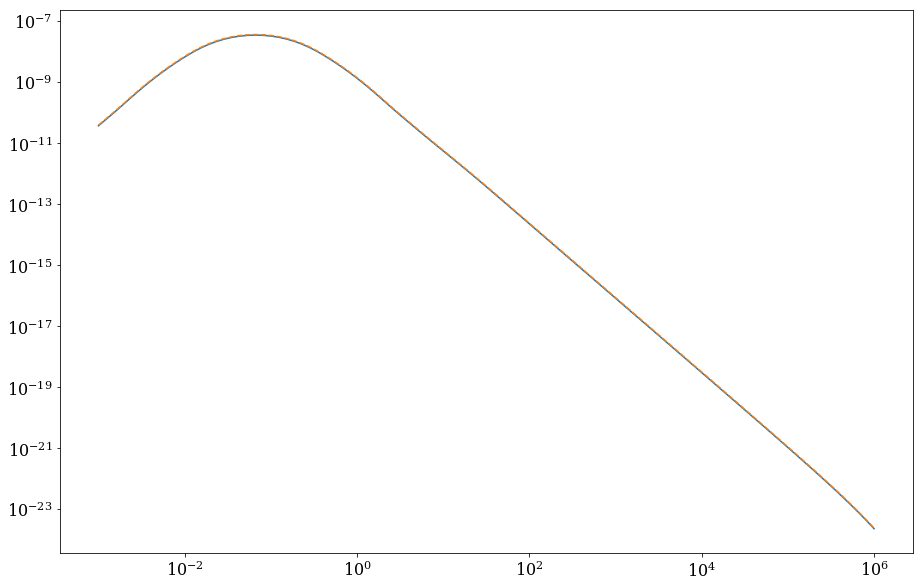

In [26]:
eng    = np.logspace(-3, 6, 100)*u.GeV
eng1, dN_dEdSdt1 = cluster.get_gamma_spectrum(eng, Rmax=1000*u.kpc, type_integral='spherical')
eng2, dN_dEdSdt2 = cluster.get_gamma_spectrum(eng, Rmax=1000*u.kpc, type_integral='cylindrical')

plt.figure(1,figsize=(15,10))
plt.loglog(eng1, dN_dEdSdt1, '')
plt.loglog(eng2, dN_dEdSdt2, '--')

In [27]:
cluster.X_cr = {'X':1e-2, 'Rcut':1000*u.kpc}

Rmax = 100*u.kpc
Nptrad = 100
eng    = np.logspace(-2, 4, 100)*u.GeV

# Method 1: parsing Naima somehow
radius1 = np.logspace(0, 4, 1000)*u.kpc
bid, nh_r  = cluster.get_density_gas_profile(radius1)
bid, ncr_r = cluster.get_normed_density_crp_profile(radius1)

V_cross = cluster_profile.get_volume_any_model(radius1.to_value('kpc'), nh_r.to_value('cm-3')*ncr_r, Rmax.to_value('kpc')) * u.kpc**3
V_auto  = cluster_profile.get_volume_any_model(radius1.to_value('kpc'), ncr_r, cluster.X_cr['Rcut'].to_value('kpc')) * u.kpc**3

CRp1 = naima.models.PowerLaw(1.0/u.GeV, 1.0*u.GeV, cluster.spectrum_crp_model['Index'])
g1 = naima.models.PionDecay(CRp1, nh=1.0*u.Unit('cm**-3'))
Unorm = cluster.X_cr['X']*cluster.get_thermal_energy_profile(cluster.X_cr['Rcut'])[1][0]
g1.set_Wp(Unorm, Epmin=cluster.Epmin, Epmax=cluster.Epmax)
dN_dEdSdt1 = (V_cross/V_auto).to_value('') * g1.flux(eng, distance=cluster.D_lum).to('MeV-1 cm-2 s-1')

# Method 3: parsing Naima with a hand defined normalization
eng3, dN_dEdSdt3 = cluster.get_gamma_spectrum(eng, Rmax=Rmax, type_integral='spherical')
    
# Method 2: direct shell integration
radius2 = np.logspace(0, np.log10(Rmax.to_value('kpc')), Nptrad)*u.kpc
bid, nh_r  = cluster.get_density_gas_profile(radius2)
bid, X_r   = cluster.get_crp_to_thermal_energy_profile(radius2)
bid, Uth_r = cluster.get_thermal_energy_profile(radius2)

CRp2 = naima.models.PowerLaw(1.0/u.GeV, 1.0*u.GeV, cluster.spectrum_crp_model['Index'])

for i in range(Nptrad):
    if i>0 : 
        UCR_shell = X_r[i].to_value('adu')*Uth_r[i] - X_r[i-1].to_value('adu')*Uth_r[i-1]
    else:
        UCR_shell = X_r[i].to_value('adu')*Uth_r[i]
    g2 = naima.models.PionDecay(CRp2, nh=nh_r[i])
    g2.set_Wp(UCR_shell,Epmin=cluster.Epmin, Epmax=cluster.Epmax)
    if i==0 : dN_dEdSdt2 = g2.flux(eng, distance=cluster.D_lum).to('MeV-1 cm-2 s-1')
    else : dN_dEdSdt2 += g2.flux(eng, distance=cluster.D_lum).to('MeV-1 cm-2 s-1')

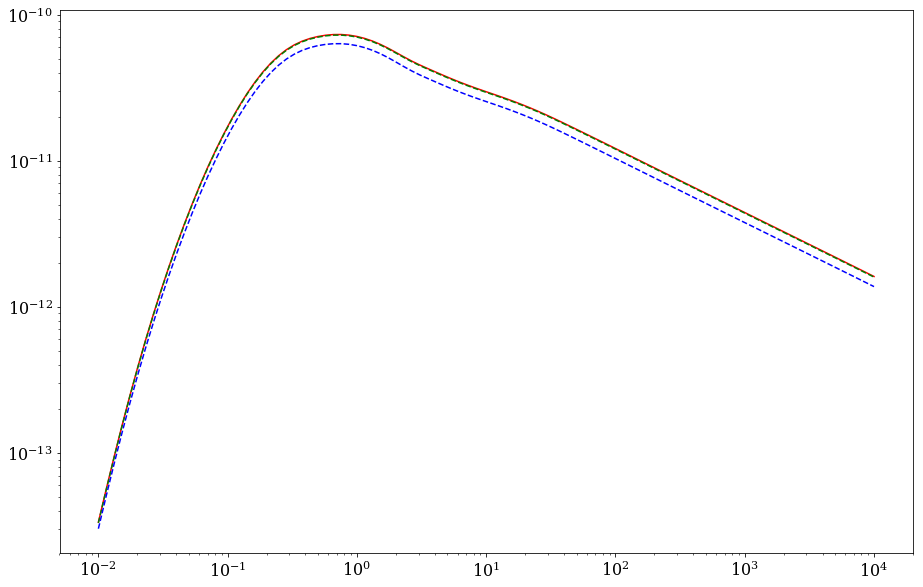

In [28]:
# Plots
plt.figure(1,figsize=(15,10))
plt.loglog(eng.to('GeV'), (eng**2*dN_dEdSdt1).to('GeV cm-2 s-1'), 'r')
plt.loglog(eng.to('GeV'), (eng**2*dN_dEdSdt2).to('GeV cm-2 s-1'), 'g--')
plt.loglog(eng.to('GeV'), (eng**2*dN_dEdSdt3).to('GeV cm-2 s-1'), 'b--')

In [29]:
# check that calculating the flux from spectrum and then profile is similar as the other way around
Emin = 10*u.MeV
Emax = 1*u.PeV
Rmax = cluster.R500

# Get the spectrum and integrate
energy=np.logspace(np.log10(Emin.to_value('GeV')),np.log10(Emax.to_value('GeV')),1000)*u.GeV
energy, dN_dEdSdt = cluster.get_gamma_spectrum(energy, Rmax=Rmax, type_integral='cylindrical')
flux1 = cluster_spectra.get_integral_any_model(energy.to_value('GeV'),
                                               dN_dEdSdt.to_value('GeV-1 cm-2 s-1'),#*energy.to_value('GeV'),
                                               Emin.to_value('GeV'), Emax.to_value('GeV')) * u.Unit('cm-2 s-1')

# Get the profile and integrate
r3d = cluster_profile.define_safe_radius_array(np.array([Rmax.to_value('kpc')]), Rmin=1.0)*u.kpc
r2d, dN_dSdtdO  = cluster.get_gamma_profile(r3d, Emin=Emin, Emax=Emax, Energy_density=False)

integrand = dN_dSdtdO.to_value('cm-2 s-1 sr-1') / cluster.D_ang.to_value('kpc')**2
flux2 = cluster_profile.get_surface_any_model(r2d.to_value('kpc'), integrand, Rmax.to_value('kpc'))*u.cm**-2*u.s**-1#*u.GeV
            
    
flux3 = cluster.get_gamma_flux(Rmax=Rmax, type_integral='cylindrical',
                       Emin=Emin, Emax=Emax, Energy_density=False)
    
flux1,flux2,flux3, (flux2-flux1)/flux2

(<Quantity 1.19527712e-08 1 / (cm2 s)>,
 <Quantity 1.19566972e-08 1 / (cm2 s)>,
 <Quantity 1.19472998e-08 1 / (cm2 s)>,
 <Quantity 0.00032835>)

# Test CRp model

In [30]:
cluster = model.Cluster()
cluster2 = model.Cluster()

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.
                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                    

Getting R500 value
Getting R_truncation value
Getting R500 value


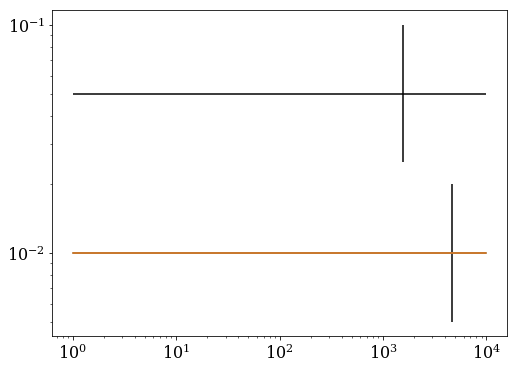

In [31]:
cluster.X_cr = {'X':1e-2, 'Rcut':cluster.R500*5}
cluster.X_cr = {'X':1e-2, 'Rcut':cluster.R_truncation}
cluster2.X_cr = {'X':5e-2, 'Rcut':cluster.R500}

#cluster.density_crp_model = {'name':'GNFW', 'a':cluster.pressure_gas_model['a'], 
#                             'b':cluster.pressure_gas_model['b'], 'c':cluster.pressure_gas_model['c'], 
#                             'r_p':cluster.pressure_gas_model['r_p']}
r, x = cluster.get_crp_to_thermal_energy_profile()
r2, x2 = cluster2.get_crp_to_thermal_energy_profile()
plt.loglog(r,x)
plt.loglog(r2,x2)
plt.hlines(cluster.X_cr['X'], 1,1e4)
plt.vlines(cluster.X_cr['Rcut'].to_value('kpc'), cluster.X_cr['X']/2,cluster.X_cr['X']*2)
plt.hlines(cluster2.X_cr['X'], 1,1e4)
plt.vlines(cluster2.X_cr['Rcut'].to_value('kpc'), cluster2.X_cr['X']/2,cluster2.X_cr['X']*2)

Setting spectrum_crp_model value
Setting spectrum_crp_model value


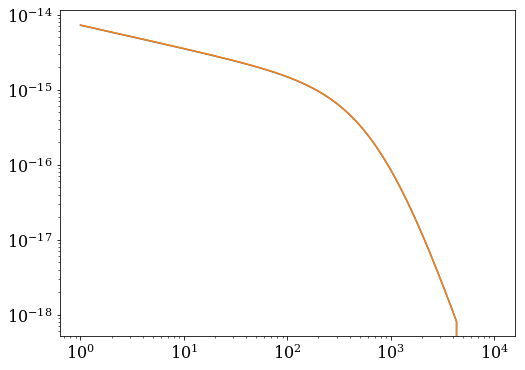

In [32]:
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':1.0}
r1, n1 = cluster.get_density_crp_profile(Emin=0.1*u.TeV, Emax=10*u.PeV)
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':1.0}
r2, n2 = cluster.get_density_crp_profile(Emin=0.1*u.TeV, Emax=100*u.PeV)
plt.loglog(r1, n1)
plt.loglog(r2, n2)

Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Getting R500 value


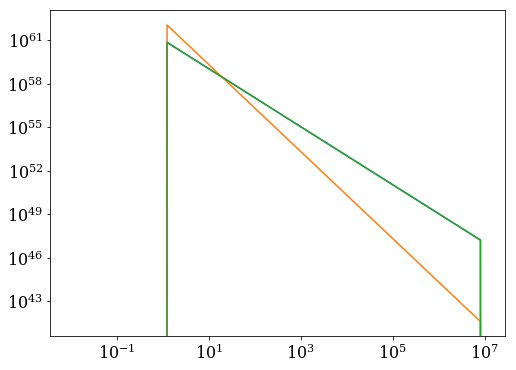

In [33]:
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.0}
e1, s1 = cluster.get_crp_spectrum(Rmax=100*u.kpc)
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':3.0}
e2, s2 = cluster.get_crp_spectrum(Rmax=100*u.kpc)
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.0}

cluster.X_cr = {'X':cluster.X_cr['X'], 'Rcut':0.1*cluster.R500}
e3, s3 = cluster.get_crp_spectrum(Rmax=100*u.kpc)

plt.loglog(e1,s1)
plt.loglog(e2,s2)
plt.loglog(e3,s3)

In [34]:
cluster.density_crp_model

Getting the cosmic ray proton density profile model value


{'P_0': <Quantity 1. adu>,
 'a': 1.33,
 'b': 4.13,
 'c': 0.31,
 'c500': 1.81,
 'name': 'GNFW',
 'r_p': <Quantity 855.62300911 kpc>}

In [35]:
cluster.density_crp_model = {'name':'GNFW', 'P_0':1, 'a':1, 'b':1, 'c':1, 'r_p':100*u.kpc}
cluster.density_crp_model = {'name':'beta', 'n_0':1, 'beta':1, 'r_c':1*u.kpc}
cluster.density_crp_model = {'name':'doublebeta', 'beta1':1, 'beta2':1, 'r_c1':1*u.kpc, 'r_c2':1*u.kpc, 'n_01':1.0, 'n_02':1.0}
cluster.density_crp_model = {'name':'SVM', 'n_0':1, 'beta':1, 'alpha':1, 'gamma':1, 'epsilon':1, 'r_c':1*u.kpc, 'r_s':1.0*u.kpc}

Setting density_crp_model value
Fixing: R500
Setting density_crp_model value
Fixing: R500
Setting density_crp_model value
Fixing: R500
Setting density_crp_model value
Fixing: R500


In [36]:
cluster.density_crp_model

Getting the cosmic ray proton density profile model value


{'alpha': 1,
 'beta': 1,
 'epsilon': 1,
 'gamma': 1,
 'n_0': <Quantity 1. adu>,
 'name': 'SVM',
 'r_c': <Quantity 1. kpc>,
 'r_s': <Quantity 1. kpc>}

In [37]:
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':1.0}
cluster.spectrum_crp_model = {'name':'ExponentialCutoffPowerLaw', 'Index':1.0, 'CutoffEnergy':1e3*u.TeV}

Setting spectrum_crp_model value
Setting spectrum_crp_model value


In [38]:
cluster.spectrum_crp_model

Getting the cosmic ray proton spectrum parameters value


{'CutoffEnergy': <Quantity 1000. TeV>,
 'Index': 1.0,
 'name': 'ExponentialCutoffPowerLaw'}

Setting density_crp_model value
Fixing: R500


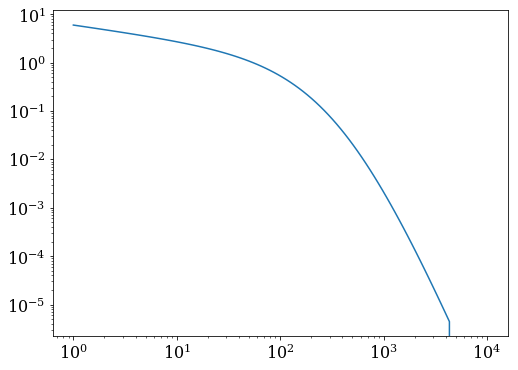

In [39]:
cluster.density_crp_model = {'name':'GNFW', 'P_0':1,'a':1.0, 'b': 5.0, 'c':0.3, 'r_p':400*u.kpc}

r, fr = cluster.get_normed_density_crp_profile()
plt.loglog(r, fr)

Setting spectrum_crp_model value
Setting Epmax value


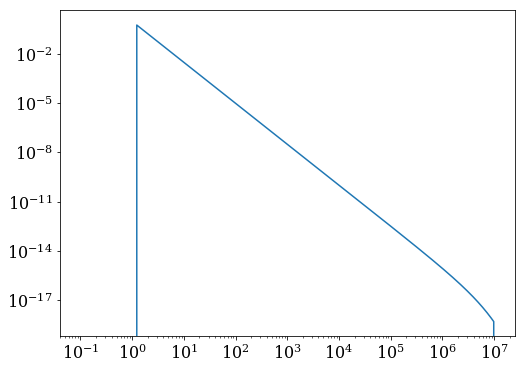

In [40]:
#cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.5}
cluster.spectrum_crp_model = {'name':'ExponentialCutoffPowerLaw', 'Index':2.5, 'CutoffEnergy':5.0*u.PeV}
cluster.Epmax = 10*u.PeV
e, fe = cluster.get_normed_crp_spectrum(np.logspace(-1,7,1000)*u.GeV)
plt.loglog(e, fe)

Getting R500 value


<Quantity [5.17217942e+63] erg>

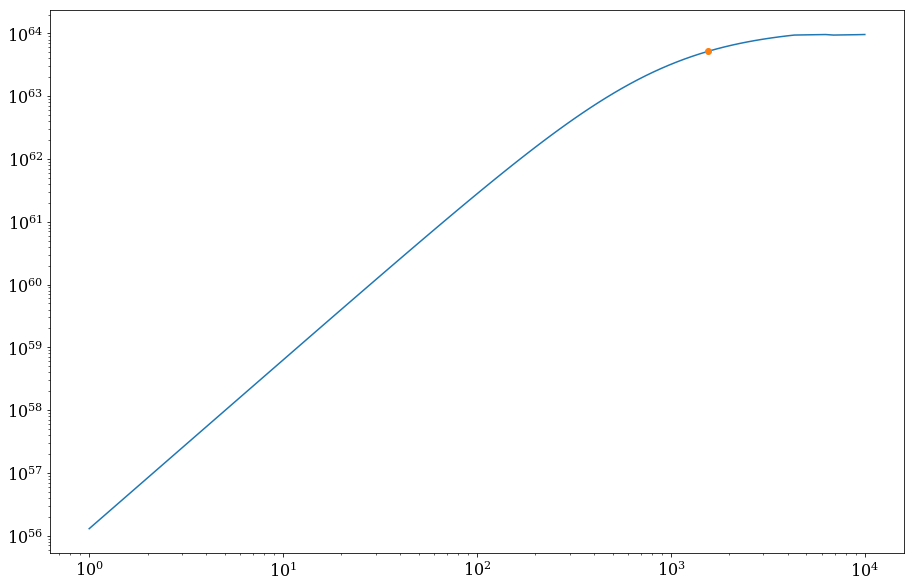

In [41]:
r, uth = cluster.get_thermal_energy_profile()
rl, uthl = cluster.get_thermal_energy_profile(cluster.R500)

plt.figure(figsize=(15,10))
plt.loglog(r, uth.to('erg'))
plt.loglog(rl, uthl.to('erg'), 'o')
uthl.to('erg')

# Test pressure, density, temperature profiles

In [42]:
cluster = model.Cluster()

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.


In [43]:
# pressure profile
cluster = model.Cluster()
#cluster.R_truncation = np.inf*u.kpc
r1, p_r1 = cluster.get_pressure_gas_profile()
cluster.set_pressure_gas_gNFW_param('A10UPP')
r2, p_r2 = cluster.get_pressure_gas_profile()
cluster.set_pressure_gas_gNFW_param('A10MD')
r3, p_r3 = cluster.get_pressure_gas_profile()
cluster.set_pressure_gas_gNFW_param('A10CC')
r4, p_r4 = cluster.get_pressure_gas_profile()
cluster.set_pressure_gas_gNFW_param('P13UPP')
r5, p_r5 = cluster.get_pressure_gas_profile()

cluster.theta500 = 0.1*u.deg
print(cluster.R500, cluster.M500)
cluster.set_pressure_gas_gNFW_param('P13UPP')
r6, p_r6 = cluster.get_pressure_gas_profile()

cluster.R_truncation = np.inf*u.kpc
r7, p_r7 = cluster.get_pressure_gas_profile()

cluster.pressure_gas_model = {'name':'GNFW', 'P_0':1*u.Unit('keV cm-3'), 'a':2.0,'b':5.0,'c':0.0, 'r_p':500.0*u.kpc}
r8, p_r8 = cluster.get_pressure_gas_profile()

cluster.set_pressure_gas_isoT_param(10*u.keV)
r9, p_r9 = cluster.get_pressure_gas_profile()

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.
Setting gNFW Arnaud et al. (2010) UPP.
Setting gNFW Arnaud et al. (2010) morphologically disturbed.
Setting gNFW Arnaud et al. (2010) cool-core.
Setting gNFW Planck coll. (2013) UPP.
Setting theta500 value
Setting: R500, M500 ; Fixing: redshift, cosmo, D_ang
Getting R500 value
Getting M500 value
(<Quantity 0.07629952 Mpc>, <Quantity 1.19586527e+11 solMass>)
Setting gNFW Planck coll. (2013) UPP.
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang
Setti

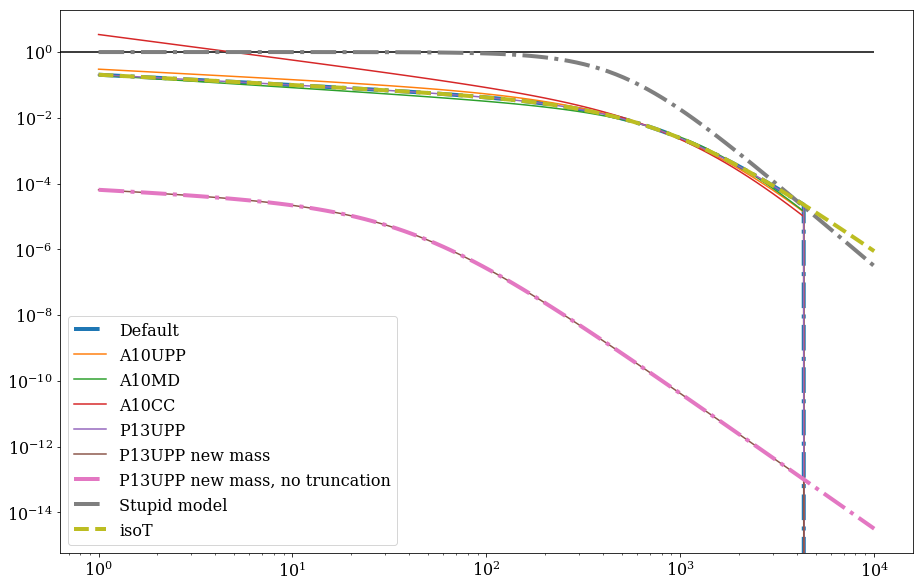

In [44]:
plt.figure(figsize=(15,10))
plt.loglog(r1, p_r1, '-.', linewidth=4, label='Default')
plt.loglog(r2, p_r2, label='A10UPP')
plt.loglog(r3, p_r3, label='A10MD')
plt.loglog(r4, p_r4, label='A10CC')
plt.loglog(r5, p_r5, label='P13UPP')
plt.loglog(r6, p_r6, label='P13UPP new mass')
plt.loglog(r7, p_r7, '-.', linewidth=4, label='P13UPP new mass, no truncation')
plt.loglog(r8, p_r8, '-.', linewidth=4, label='Stupid model')
plt.loglog(r9, p_r9, '--', linewidth=4, label='isoT')
plt.hlines(1,0,1e4)
plt.legend()

In [45]:
cluster.density_gas_model = {'name':'doublebeta', 
                             'n_01':1e-2*u.Unit('cm-3'), 'beta1':2.0, 'r_c1':500.0*u.kpc,
                             'n_02':1e-2*u.Unit('cm-3'), 'beta2':2.0, 'r_c2':500.0*u.kpc}
print(cluster.density_gas_model)

cluster.density_gas_model = {'name':'SVM', 
                            'n_0':1.0*u.cm**-3,'beta':1,'r_c':100*u.kpc,'r_s':1*u.kpc, 
                             'alpha':1, 'gamma':1, 'epsilon':1}
print(cluster.density_gas_model)

Setting density_gas_model value
Fixing: R500
Getting the gas electron density profile model value
{'name': 'doublebeta', 'beta2': 2.0, 'beta1': 2.0, 'n_01': <Quantity 0.01 1 / cm3>, 'n_02': <Quantity 0.01 1 / cm3>, 'r_c1': <Quantity 500. kpc>, 'r_c2': <Quantity 500. kpc>}
Setting density_gas_model value
Fixing: R500
Getting the gas electron density profile model value
{'beta': 1, 'r_s': <Quantity 1. kpc>, 'name': 'SVM', 'epsilon': 1, 'alpha': 1, 'r_c': <Quantity 100. kpc>, 'n_0': <Quantity 1. 1 / cm3>, 'gamma': 1}


In [46]:
cluster.R_truncation = 2500*u.kpc

cluster.density_gas_model = {'name':'doublebeta', 
                             'n_01':1e-2*u.Unit('cm-3'), 'beta1':2.0, 'r_c1':100.0*u.kpc,
                             'n_02':1e-3*u.Unit('cm-3'), 'beta2':0.5, 'r_c2':500.0*u.kpc}
r1, n_r1 = cluster.get_density_gas_profile()

cluster.density_gas_model = {'name':'beta', 
                             'n_0':1e-3*u.Unit('cm-3'), 'beta':0.5, 'r_c':500.0*u.kpc}
r2, n_r2 = cluster.get_density_gas_profile()

cluster.density_gas_model = {'name':'SVM', 
                            'n_0':1e-3*u.cm**-3,'beta':0.5,'r_c':500*u.kpc,'r_s':5000*u.kpc, 
                             'alpha':0.3, 'gamma':3, 'epsilon':15.0}
r3, n_r3 = cluster.get_density_gas_profile()

Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang
Setting density_gas_model value
Fixing: R500
Setting density_gas_model value
Fixing: R500
Setting density_gas_model value
Fixing: R500


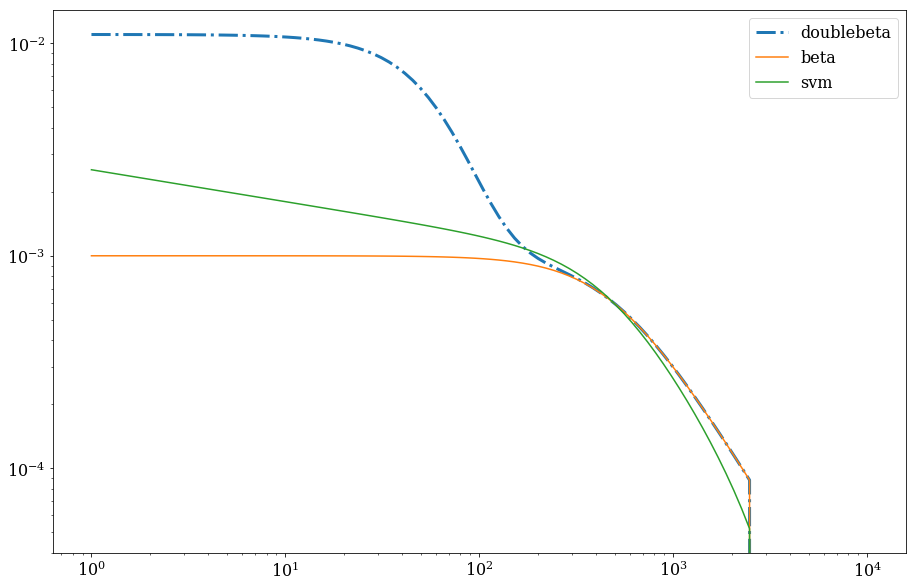

In [47]:
plt.figure(figsize=(15,10))
plt.loglog(r1, n_r1, '-.', linewidth=3, label='doublebeta')
plt.loglog(r2, n_r2, label='beta')
plt.loglog(r3, n_r3, label='svm')
plt.legend()

In [48]:
cluster.set_pressure_gas_gNFW_param('P13UPP')

r1, T_r1 = cluster.get_temperature_gas_profile()
cluster.density_gas_model = {'name':'doublebeta', 
                             'n_01':1e-1*u.Unit('cm-3'), 'beta1':1.5, 'r_c1':50.0*u.kpc,
                             'n_02':1e-3*u.Unit('cm-3'), 'beta2':0.5, 'r_c2':500.0*u.kpc}
cluster.set_pressure_gas_gNFW_param('A10MD')
r2, T_r2 = cluster.get_temperature_gas_profile()

Setting gNFW Planck coll. (2013) UPP.
Setting density_gas_model value
Fixing: R500
Setting gNFW Arnaud et al. (2010) morphologically disturbed.


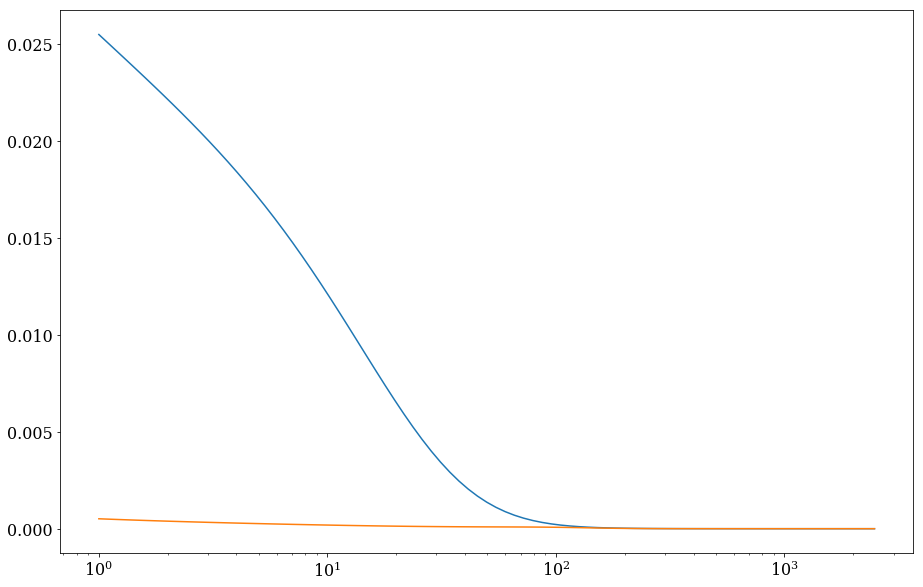

In [49]:
plt.figure(figsize=(15,10))
plt.plot(r1, T_r1)
plt.plot(r2, T_r2)
plt.xscale('log')

# Derived mass and integrated quantities

In [50]:
cluster = model.Cluster()
cluster.R_truncation = 5000.0*u.kpc#np.inf*u.kpc
print(cluster.R500)
print(cluster.M500)

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang
Getting R500 value
1548.6776465 kpc
Getting M500 value
1e+15 solMass


In [51]:
cluster.set_pressure_gas_gNFW_param('A10CC')
cluster.density_gas_model = {'name':'SVM', 
                             'n_0':3e-2*u.cm**-3,'beta':0.0,'r_c':50.0*u.kpc,'r_s':500.0*u.kpc, 
                             'alpha':0.8, 'gamma':1.0, 'epsilon':6.0}

Setting gNFW Arnaud et al. (2010) cool-core.
Setting density_gas_model value
Fixing: R500


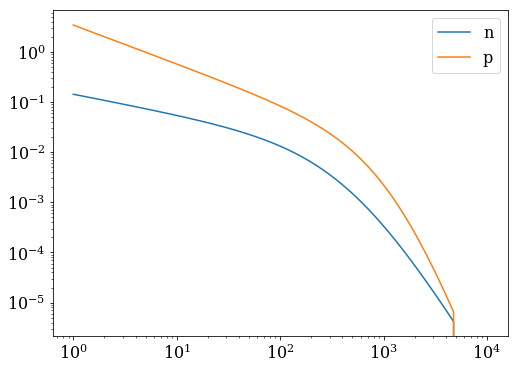

In [52]:
r,p = cluster.get_pressure_gas_profile()
r,n = cluster.get_density_gas_profile()
plt.loglog(r, n, label='n')
plt.loglog(r,p, label='p')
plt.legend()

In [53]:
r, mhse = cluster.get_hse_mass_profile()

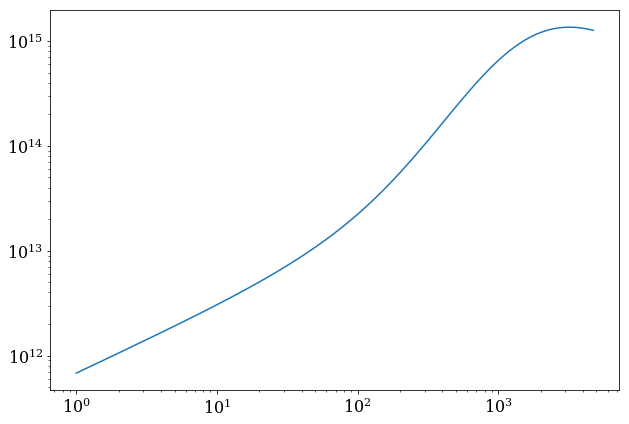

In [54]:
plt.figure(figsize=(10,7))
plt.plot(r, mhse)
plt.xscale('log')
plt.yscale('log')

Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang
The truncation was reached before R200
nan solMass


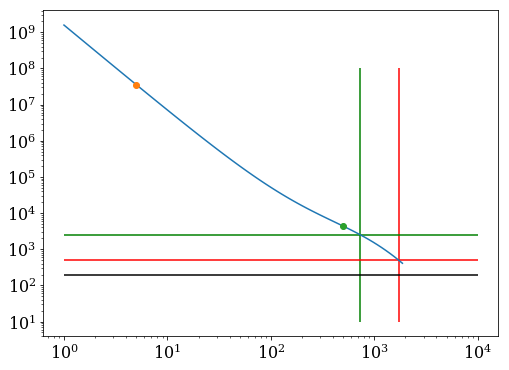

In [55]:
cluster.R_truncation = 2000.0*u.kpc#np.inf*u.kpc

r, delta = cluster.get_overdensity_contrast_profile()
r1, delta1 = cluster.get_overdensity_contrast_profile(5*u.kpc)
r2, delta2 = cluster.get_overdensity_contrast_profile(500*u.kpc)
r2500_p, m2500_p = cluster.get_mdelta_from_profile(2500, 10*u.kpc, 1e5*u.kpc)
r500_p, m500_p = cluster.get_mdelta_from_profile(500, 10*u.kpc, 1e4*u.kpc)
r200_p, m200_p = cluster.get_mdelta_from_profile(200, 10*u.kpc, 1e5*u.kpc)
plt.loglog(r, delta)
plt.loglog(r1, delta1, 'o')
plt.loglog(r2, delta2, 'o')
plt.vlines(r2500_p.to_value('kpc'), 10, 1e8, color='g')
plt.vlines(r500_p.to_value('kpc'), 10, 1e8, color='r')
plt.vlines(r200_p.to_value('kpc'), 10, 1e8)
plt.hlines(2500, 1e0, 1e4, color='g')
plt.hlines(500, 1e0, 1e4, color='r')
plt.hlines(200, 1e0, 1e4)
print(m200_p)

(100000000.0, 100000000000.0)

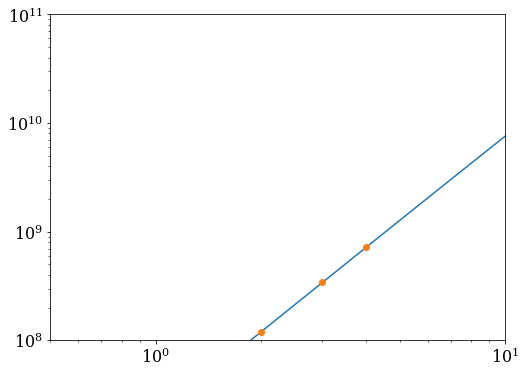

In [56]:
r, mgas = cluster.get_gas_mass_profile()
r1, mgas1 = cluster.get_gas_mass_profile([1,2,3,4]*u.kpc)
plt.loglog(r, mgas)
plt.loglog(r1, mgas1, 'o')
plt.xlim(0.5,10)
plt.ylim(1e8,1e11)

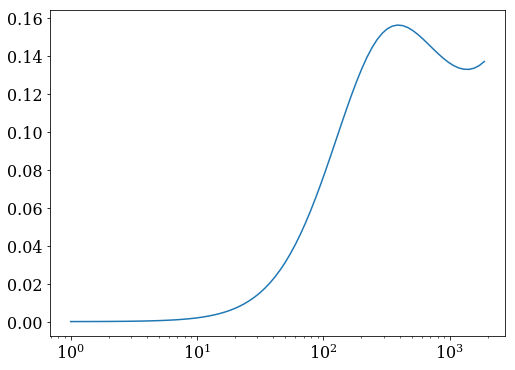

In [57]:
r, fgas = cluster.get_fgas_profile()
plt.plot(r, fgas)
plt.xscale('log')

In [58]:
r,n = cluster.get_density_gas_profile(100.0*u.kpc)
print(r, n)

(<Quantity [100.] kpc>, <Quantity [0.01315726] 1 / cm3>)


# Compton parameter

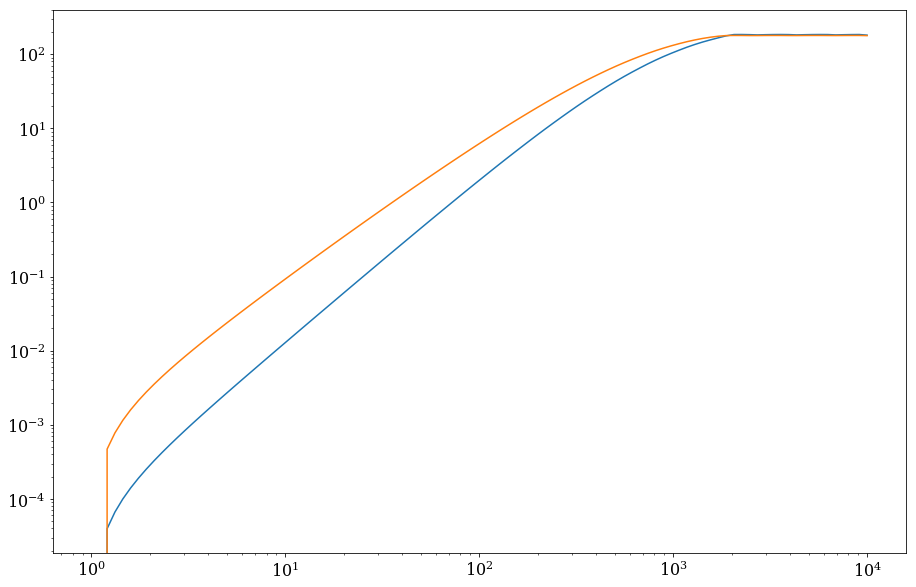

In [59]:
r = np.logspace(0,4,100)*u.kpc
plt.figure(figsize=(15,10))
ysph = cluster.get_sz_flux(Rmax=r, Compton_only=True, type_integral='spherical')
ycyl = cluster.get_sz_flux(Rmax=r, Compton_only=True, type_integral='cylindrical')
plt.loglog(r, ysph)
plt.loglog(r, ycyl)

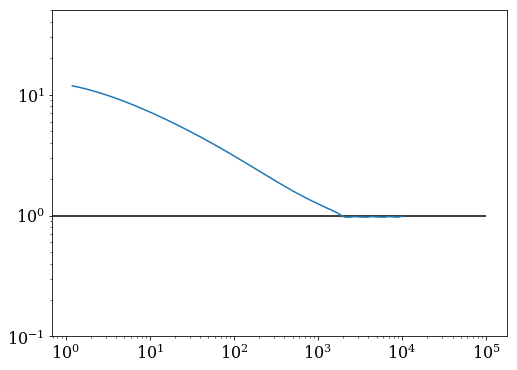

In [60]:
plt.plot(r, ycyl/ysph)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1,50)
plt.hlines(1,0,1e5)

Getting R500 value
1548.6776465 kpc
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang
Getting R500 value
Getting R500 value


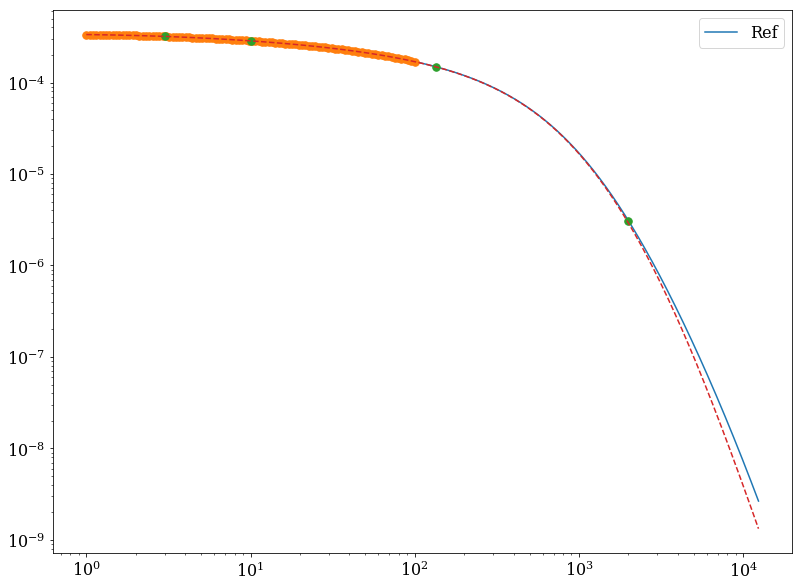

In [61]:
print(cluster.R500)
cluster.R_truncation = np.inf*u.kpc
Rp, y = cluster.get_sz_profile(np.logspace(0,np.log10(8*cluster.R500.to_value('kpc')),1000)*u.kpc, Compton_only=True)
Rp3, y3 = cluster.get_sz_profile(np.logspace(0,np.log10(8*cluster.R500.to_value('kpc')),1000)*u.kpc,NR500_los=2, Compton_only=True)
Rp1, y1 = cluster.get_sz_profile(np.logspace(0,2, 100)*u.kpc,Compton_only=True)
Rp2, y2 = cluster.get_sz_profile([3,10,135,2000]*u.kpc,Compton_only=True)
plt.figure(figsize=(13,10))
plt.plot(Rp, y, label='Ref')
plt.plot(Rp1, y1, '.', markersize=15)
plt.plot(Rp2, y2, '.', markersize=15)
plt.plot(Rp3, y3, '--', markersize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [62]:
r, m = cluster.get_gas_mass_profile()
r2, m2 = cluster.get_gas_mass_profile(600*u.kpc)

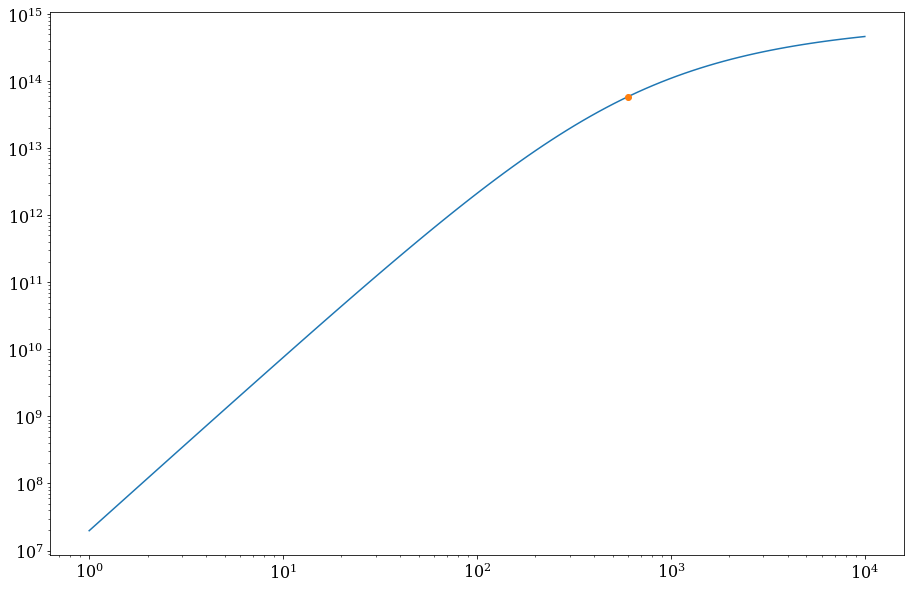

In [63]:
plt.figure(figsize=(15,10))
plt.loglog(r, m)
plt.loglog(r2, m2, 'o')

In [64]:
r, m = cluster.get_fgas_profile()
r2,m2 = cluster.get_fgas_profile(600*u.kpc)
r3,m3 = cluster.get_fgas_profile(1200*u.kpc)

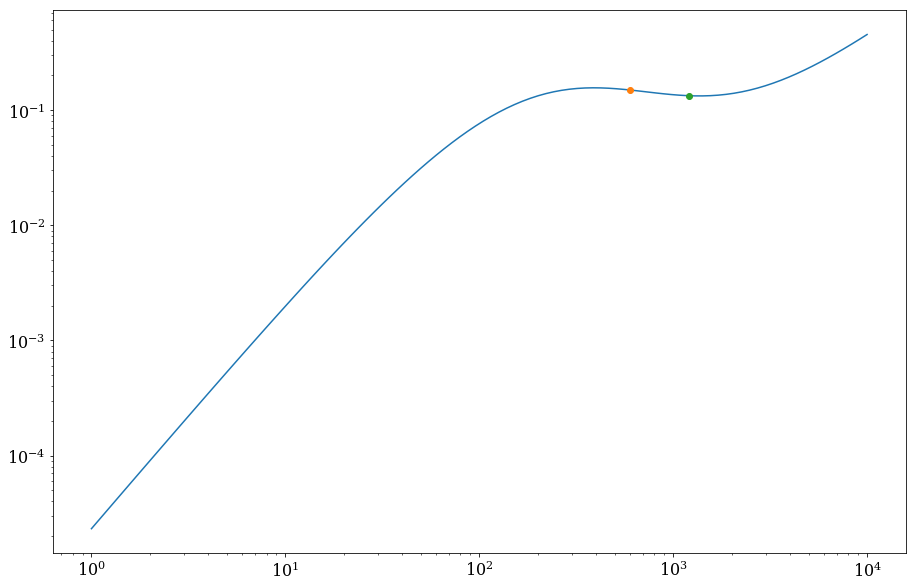

In [65]:
plt.figure(figsize=(15,10))
plt.loglog(r, m)
plt.loglog(r2, m2, 'o')
plt.loglog(r3, m3, 'o')

# Maps

In [66]:
# Extract a map as template

reso_out = 1.0/60          # Pixel size in deg
FoV_out  = 6.0             # Size of the field of view
coord1    = SkyCoord("03h19m47.2s +41d30m47s", frame="icrs", unit="deg") # Perseus
coord2    = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg") # Coma

dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file  = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'
ymap1, header1 = map_tools.roi_extract_healpix(ymap_file, coord1.ra.value, coord1.dec.value, 
                                   reso_out, [FoV_out, FoV_out], visu=False)
ymap2, header2 = map_tools.roi_extract_healpix(ymap_file, coord2.ra.value, coord2.dec.value, 
                                   reso_out, [FoV_out, FoV_out], visu=False)
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))
sm = 5.0
ymap1 = ndimage.gaussian_filter(ymap1, sigma=(FWHM2sigma*sm/60/reso_out, FWHM2sigma*sm/60/reso_out), order=0)
ymap2 = ndimage.gaussian_filter(ymap2, sigma=(FWHM2sigma*sm/60/reso_out, FWHM2sigma*sm/60/reso_out), order=0)

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [67]:
# Model Perseus
cluster1 = model.Cluster()
cluster1.R_truncation = np.inf*u.kpc
cluster1.M500 = 7e14*u.Msun
cluster1.redshift = 0.0179
cluster1.coord = {'RA':coord1.ra, 'Dec':coord1.dec}
cluster1.set_pressure_gas_gNFW_param('P13UPP')

#cluster1.map_coord = coord1
#cluster1.map_reso = reso_out*u.deg
#cluster1.map_fov = [FoV_out, FoV_out]*u.deg
cluster1.map_header = header1

# Model Coma
cluster2 = model.Cluster()
cluster2.R_truncation = np.inf*u.kpc
cluster2.M500 = 6e14*u.Msun
cluster2.redshift = 0.023
cluster2.coord = {'RA':coord2.ra, 'Dec':coord2.dec}
cluster2.set_pressure_gas_gNFW_param('P13UPP')

#cluster2.map_coord = coord2
#cluster2.map_reso = reso_out*u.deg
#cluster2.map_fov = [FoV_out, FoV_out]*u.deg
cluster2.map_header = header2

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang
Setting M500 value
Setting: R500, theta500 ; Fixing: redshift, cosmo, D_ang
Setting redshift value
Setting: D_ang, D_lum, R500, theta500, theta_truncation ; Fixing: cosmo.
Setting coord value
Setting gNFW Planck coll. (2013) UPP.
Setting the map header
Setting: map_coord, map_reso, map_fov to None, as the header will be used
                      ___   __    ___   __   __                      
      

In [68]:
# Get the model ymaps
h1 = cluster1.get_map_header()
y1 = cluster1.get_sz_map(Compton_only=True)
h2 = cluster2.get_map_header()
y2 = cluster2.get_sz_map(Compton_only=True)

Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates


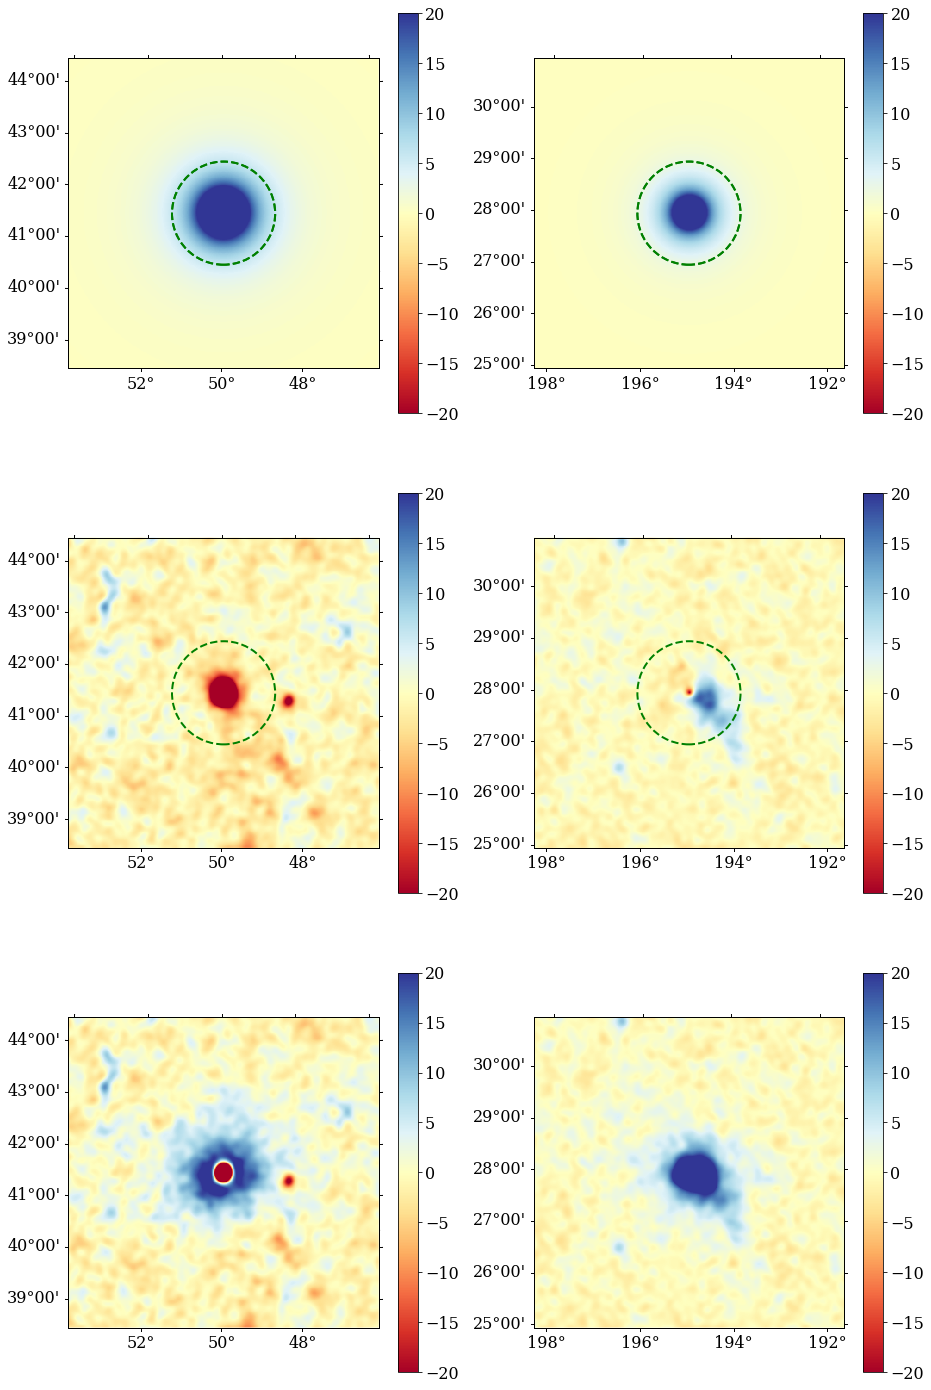

In [69]:
rad_show = 1.0

fig = plt.figure(1, figsize=(15, 25))

# Model 1
ax1 = plt.subplot(321, projection=WCS(h1))
plt.imshow(1e6*y1, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((cluster1.coord.ra.value, cluster1.coord.dec.value),
                                        2*rad_show/np.cos(cluster1.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax1.get_transform('fk5'))
ax1.add_patch(circle_500)
plt.colorbar()

# Model 2
ax2 = plt.subplot(322, projection=WCS(h2))
plt.imshow(1e6*y2, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((cluster2.coord.ra.value, cluster2.coord.dec.value),
                                        2*rad_show/np.cos(cluster2.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax2.get_transform('fk5'))
ax2.add_patch(circle_500)
plt.colorbar()

# Model 1 - Perseus
ax3 = plt.subplot(323, projection=WCS(h1))
plt.imshow(1e6*(ymap1-y1.to_value('adu')), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((cluster1.coord.ra.value, cluster1.coord.dec.value),
                                        2*rad_show/np.cos(cluster1.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax3.get_transform('fk5'))
ax3.add_patch(circle_500)
plt.colorbar()

# Model 2 - Coma
ax4 = plt.subplot(324, projection=WCS(h2))
plt.imshow(1e6*(ymap2-y2.to_value('adu')), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((cluster2.coord.ra.value, cluster2.coord.dec.value),
                                        2*rad_show/np.cos(cluster2.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax4.get_transform('fk5'))
ax4.add_patch(circle_500)
plt.colorbar()

# Perseus
ax5 = plt.subplot(325, projection=WCS(header1))
plt.imshow(1e6*ymap1, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((coord1.ra.value, coord1.dec.value),
                                        2*rad_show/np.cos(coord1.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax1.get_transform('fk5'))
ax1.add_patch(circle_500)
plt.colorbar()

# Coma
ax6 = plt.subplot(326, projection=WCS(header2))
plt.imshow(1e6*ymap2, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((coord2.ra.value, coord2.dec.value),
                                        2*rad_show/np.cos(coord2.dec.value*np.pi/180),2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax2.get_transform('fk5'))
ax2.add_patch(circle_500)
plt.colorbar()